In [1]:
%matplotlib inline

In [2]:
import os
import sys

spark_home = os.environ['SPARK_HOME']
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.4-src.zip'))

In [3]:
from __future__ import print_function, division
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession

import seaborn as sns
import pandas as pd

import time
import os
import csv
from numpy import array

spark = SparkSession.builder.master("local[2]") \
   .appName("test") \
   .enableHiveSupport() \
   .getOrCreate()

sc = spark.sparkContext

In [5]:
!hadoop fs -put ../data/sample_libsvm_data.txt /data/
training = spark.read.format("libsvm").load("/data/sample_libsvm_data.txt")

In [6]:
training.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(692,[127,128,129...|
|  1.0|(692,[158,159,160...|
|  1.0|(692,[124,125,126...|
|  1.0|(692,[152,153,154...|
|  1.0|(692,[151,152,153...|
|  0.0|(692,[129,130,131...|
|  1.0|(692,[158,159,160...|
|  1.0|(692,[99,100,101,...|
|  0.0|(692,[154,155,156...|
|  0.0|(692,[127,128,129...|
|  1.0|(692,[154,155,156...|
|  0.0|(692,[153,154,155...|
|  0.0|(692,[151,152,153...|
|  1.0|(692,[129,130,131...|
|  0.0|(692,[154,155,156...|
|  1.0|(692,[150,151,152...|
|  0.0|(692,[124,125,126...|
|  0.0|(692,[152,153,154...|
|  1.0|(692,[97,98,99,12...|
|  1.0|(692,[124,125,126...|
+-----+--------------------+
only showing top 20 rows



In [7]:
#http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#module-pyspark.ml.classification
#https://mingchen0919.github.io/learning-apache-spark/regularization.html

lr = LogisticRegression(maxIter=20)

In [8]:
lrModel = lr.fit(training)

In [9]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

In [10]:
trainingSummary.areaUnderROC

1.0

In [11]:
trainingSummary.roc

DataFrame[FPR: double, TPR: double]

In [12]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

objectiveHistory:
0.6833149135741672
0.16990816982625645
0.04156251230059469
0.014990287131760512
0.0021906450598322682
0.0017470485320291176
0.001088635632265231
0.0007539606109381006
0.00044711266872186906
0.0002782591434332432
0.00018538349870697403
0.0001368749700101
4.911584203906704e-05
2.7692749430426285e-05
1.4312314698982617e-05
7.67937578214286e-06
4.147729667042558e-06
2.2962551540462557e-06
1.2228711423520755e-06
6.272756794835256e-07
3.2072338788033853e-07


In [13]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.017543859649122806|
|0.0| 0.03508771929824561|
|0.0| 0.05263157894736842|
|0.0| 0.07017543859649122|
|0.0| 0.08771929824561403|
|0.0| 0.10526315789473684|
|0.0| 0.12280701754385964|
|0.0| 0.14035087719298245|
|0.0| 0.15789473684210525|
|0.0| 0.17543859649122806|
|0.0| 0.19298245614035087|
|0.0| 0.21052631578947367|
|0.0| 0.22807017543859648|
|0.0| 0.24561403508771928|
|0.0|  0.2631578947368421|
|0.0|  0.2807017543859649|
|0.0|  0.2982456140350877|
|0.0|  0.3157894736842105|
|0.0|  0.3333333333333333|
+---+--------------------+
only showing top 20 rows

areaUnderROC: 1.0


In [14]:
roc_df = trainingSummary.roc.toPandas()

In [15]:
roc_df.head()

,FPR,TPR
0,0.0,0.000000
1,0.0,0.017544
2,0.0,0.035088
3,0.0,0.052632
4,0.0,0.070175


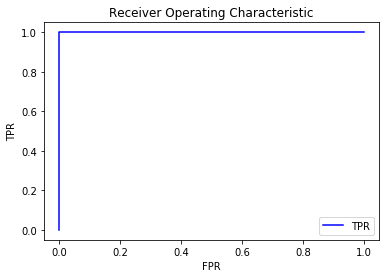

In [16]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(roc_df.FPR, roc_df.TPR, 'b')
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [17]:
#https://baike.baidu.com/item/f-measure
fMeasure = trainingSummary.fMeasureByThreshold

In [18]:
fMeasure.show()

+------------------+--------------------+
|         threshold|           F-Measure|
+------------------+--------------------+
|0.9999999999620854|0.034482758620689655|
| 0.999999999949787| 0.06779661016949151|
|0.9999999999062372|                 0.1|
|0.9999999999049627| 0.13114754098360656|
|0.9999999999025662| 0.16129032258064516|
| 0.999999999869404|  0.1904761904761905|
|0.9999999998402802|             0.21875|
|0.9999999998359725| 0.24615384615384614|
|0.9999999996637787|  0.2727272727272727|
|0.9999999981136287| 0.29850746268656714|
|0.9999999979504939|  0.3235294117647059|
|0.9999999973637561| 0.34782608695652173|
|0.9999999967452371|  0.3714285714285714|
|0.9999999949612357|  0.3943661971830986|
|0.9999999938001025|  0.4166666666666667|
|0.9999999925403699|  0.4383561643835616|
|0.9999999903463642| 0.45945945945945943|
| 0.999999987469487|  0.4799999999999999|
|0.9999999852365893|                 0.5|
|0.9999999801995776|  0.5194805194805194|
+------------------+--------------

In [19]:
# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']


In [20]:
bestThreshold

0.9999973267408881

In [21]:
fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']).show()

+------------------+---------+
|         threshold|F-Measure|
+------------------+---------+
|0.9999973267408881|      1.0|
+------------------+---------+



In [22]:
lr.setThreshold(bestThreshold)

LogisticRegression_414795497465afabfbeb

In [23]:
model2 = lr.fit(training)

In [24]:
trainingSummary2 = model2.summary

In [25]:
trainingSummary2.areaUnderROC

1.0

In [26]:
spark.stop()